データを読み込んでいます...
 - smart_home_0101.csv: 読み込み完了 (1786 行)
 - smart_home_1229-1.csv: 読み込み完了 (3389 行)
 - smart_home_1231.csv: 読み込み完了 (3095 行)
使用する特徴量の数: 81

 Living の人数推定を開始します (Target: Label_Living_Count)
[Living] データ拡張中...
[Living] 学習データ数: 23156
[Living] モデル学習中...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data.ffill(inplace=True)
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to


★ Living 正解率 (Accuracy): 0.9770
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1676
           1       0.97      0.98      0.97       310
           2       0.95      0.96      0.95       495

    accuracy                           0.98      2481
   macro avg       0.97      0.97      0.97      2481
weighted avg       0.98      0.98      0.98      2481



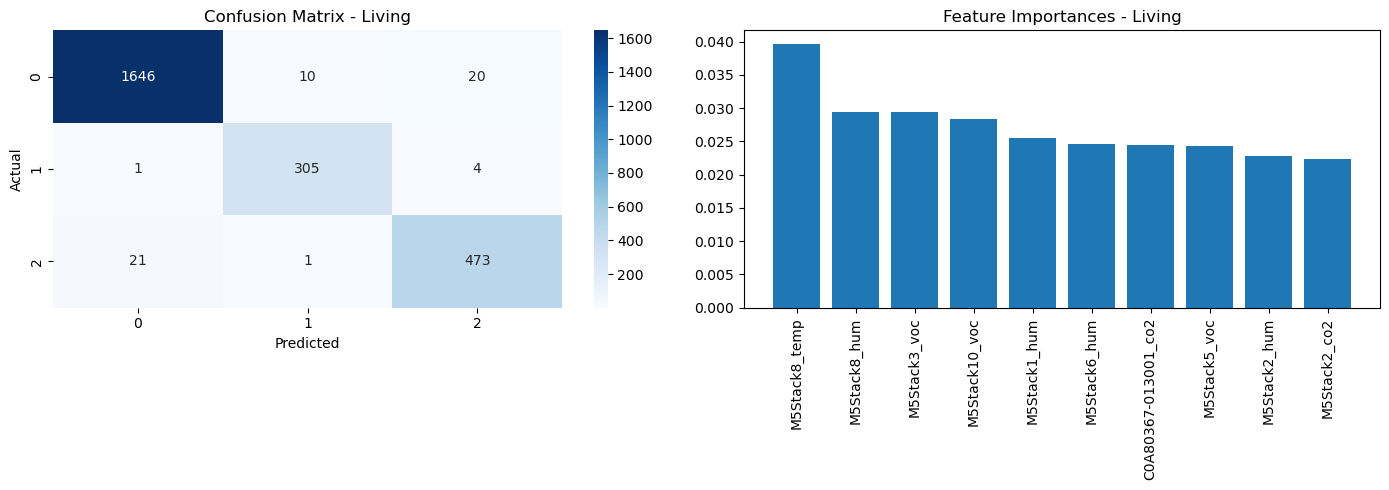


 Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)
[Japanese (Washitu)] データ拡張中...
[Japanese (Washitu)] 学習データ数: 23156
[Japanese (Washitu)] モデル学習中...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[:, col] = X[col].astype(int)
/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/254101194.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  X.loc[


★ Japanese (Washitu) 正解率 (Accuracy): 0.9871
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2000
           1       0.95      0.99      0.97       186
           2       0.97      0.95      0.96       295

    accuracy                           0.99      2481
   macro avg       0.97      0.98      0.97      2481
weighted avg       0.99      0.99      0.99      2481



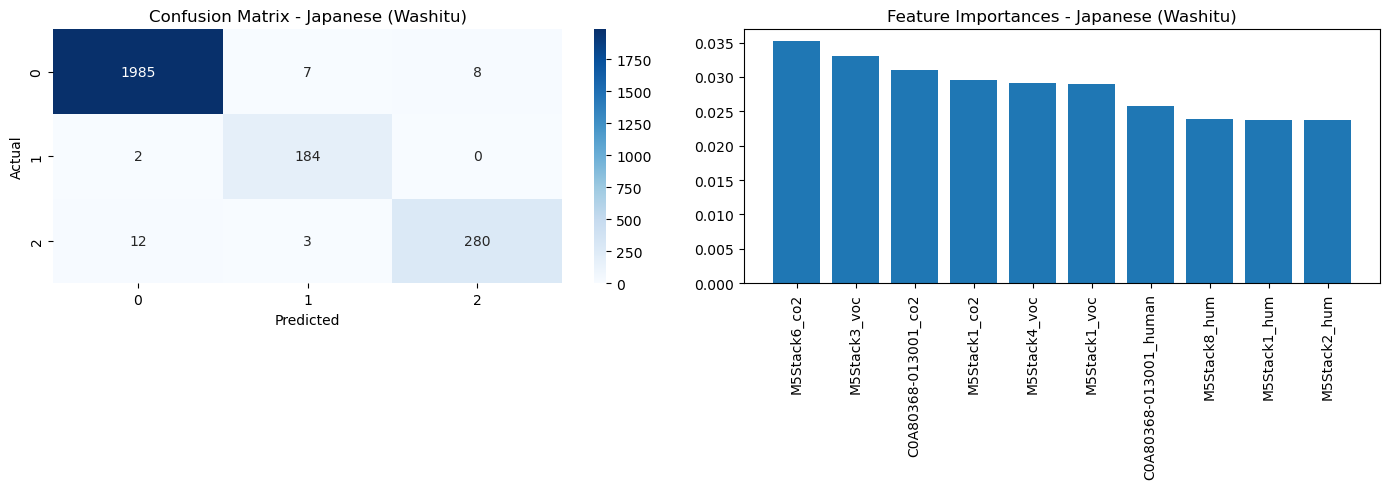

In [11]:
# ==============================================================================
# ライブラリのインポート
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ==============================================================================
# 1. データの読み込み
# ==============================================================================
file_names = ["smart_home_0101.csv", "smart_home_1229-1.csv", "smart_home_1231.csv"]
data_list = []

print("データを読み込んでいます...")
for file in file_names:
    try:
        df = pd.read_csv(file)
        data_list.append(df)
        print(f" - {file}: 読み込み完了 ({len(df)} 行)")
    except FileNotFoundError:
        print(f" - {file}: ファイルが見つかりません。")

if not data_list:
    raise ValueError("読み込めるデータがありませんでした。")

full_data = pd.concat(data_list, ignore_index=True)

# タイムスタンプでソート
if 'timestamp' in full_data.columns:
    full_data['timestamp'] = pd.to_datetime(full_data['timestamp'])
    full_data = full_data.sort_values('timestamp').reset_index(drop=True)

# ==============================================================================
# 2. 前処理 (共通)
# ==============================================================================
full_data.ffill(inplace=True)
full_data.fillna(0, inplace=True)

# 特徴量の自動選択 (全センサーを使用)
sensor_cols = [c for c in full_data.columns if any(x in c for x in ['_co2', '_temp', '_hum', '_voc', '_pm2_5'])]
pir_cols = [c for c in full_data.columns if 'PIR' in c]
features = sensor_cols + pir_cols

print(f"使用する特徴量の数: {len(features)}")

# ==============================================================================
# 3. データオーグメンテーション関数
# ==============================================================================
def augment_data(X, y, noise_level=0.05, shift_steps=[-1, 1]):
    X_aug_list = [X]
    y_aug_list = [y]

    # 1. ノイズ付加
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    noise = np.random.normal(0, noise_level, X[numeric_cols].shape)
    X_noise = X.copy()
    X_noise[numeric_cols] = X_noise[numeric_cols] + noise
    X_aug_list.append(X_noise)
    y_aug_list.append(y)

    # 2. タイムシフト
    for step in shift_steps:
        X_shifted = X.shift(step).bfill().ffill()
        X_aug_list.append(X_shifted)
        y_aug_list.append(y)

    return pd.concat(X_aug_list, ignore_index=True), pd.concat(y_aug_list, ignore_index=True)

# ==============================================================================
# 4. 学習と評価のループ (リビング・和室 それぞれ実行)
# ==============================================================================
target_rooms = {
    'Living': 'Label_Living_Count',
    'Japanese (Washitu)': 'Label_Japanese_Count'
}

for room_name, target_col in target_rooms.items():
    print(f"\n" + "="*60)
    print(f" {room_name} の人数推定を開始します (Target: {target_col})")
    print("="*60)

    # ターゲットがない場合はスキップ
    if target_col not in full_data.columns:
        print(f"エラー: {target_col} がデータに含まれていません。スキップします。")
        continue

    # モデル用データの作成
    df_model = full_data[features + [target_col]].copy()
    df_model.dropna(subset=[target_col], inplace=True)

    X = df_model[features]
    y = df_model[target_col]

    # Boolean -> Int
    for col in X.select_dtypes(include=['bool']).columns:
        X.loc[:, col] = X[col].astype(int)

    # 分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

    # データ拡張
    print(f"[{room_name}] データ拡張中...")
    X_train_aug, y_train_aug = augment_data(X_train, y_train, noise_level=0.05, shift_steps=[-1, 1])
    print(f"[{room_name}] 学習データ数: {len(X_train_aug)}")

    # 学習
    print(f"[{room_name}] モデル学習中...")
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1)
    model.fit(X_train_aug, y_train_aug)

    # 評価
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n★ {room_name} 正解率 (Accuracy): {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # --- 可視化 ---
    plt.figure(figsize=(14, 5))

    # 混同行列
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {room_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # 特徴量重要度 (Top 10)
    plt.subplot(1, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    plt.title(f"Feature Importances - {room_name}")
    plt.bar(range(10), importances[indices], align="center")
    plt.xticks(range(10), [features[i] for i in indices], rotation=90)

    plt.tight_layout()
    plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ==========================================
# 1. データ準備（ここはご自身の環境に合わせてください）
# ==========================================
# df = pd.read_csv("your_data.csv")
# X = df[['co2', 'temperature', 'pir', ...]]
# y = df['Label_Japanese_Count']
# ==========================================

# ★修正1: 警告対策（SettingWithCopyWarning）
# 明示的に .copy() することで、メモリ上で独立させます
X = X.copy()
y = y.copy()

print("============================================================")
print("Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)")
print("============================================================")

# ★修正2: 警告対策（FutureWarning / Boolean型）
# True/False の列を 1/0 に変換する処理（もしあれば）
# .locなどは使わず、シンプルに列全体を更新します
# （数値データだけの列ならこの処理はスキップされます）
for col in X.select_dtypes(include=["bool"]).columns:
    X[col] = X[col].astype(int)

# ★修正3: 警告対策（fillnaの古い書き方を修正）
# もしラグ特徴量（1つ前のデータなど）を作っている場合
# X_shifted = X.shift(1).fillna(method='bfill') # ← 古い書き方
# X_shifted = X.shift(1).bfill().ffill()        # ← 新しい書き方（例として記載）

# ------------------------------------------------------------
# 2. データの分割（時系列を考慮）
# ------------------------------------------------------------
# ★修正4: カンニング防止 (shuffle=False)
# 過去のデータで学習し、未来のデータを予測させます
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42  # ← ここをFalseにするのが重要！
)

print(f"[Japanese (Washitu)] 学習データ数: {len(X_train)}")
print(f"[Japanese (Washitu)] テストデータ数: {len(X_test)}")

# ------------------------------------------------------------
# 3. モデル学習
# ------------------------------------------------------------
print("[Japanese (Washitu)] モデル学習中...")

# ★修正5: 不均衡データ対策 (class_weight='balanced')
# 人数が少ないクラス（2人など）を間違えたときに、ペナルティを重くします
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced",  # ← これで「見逃し」が減ります
    n_jobs=-1,  # 計算を並列化して高速化
)

model.fit(X_train, y_train)

# ------------------------------------------------------------
# 4. 評価
# ------------------------------------------------------------
y_pred = model.predict(X_test)

print(f"★ Japanese (Washitu) 正解率 (Accuracy): {accuracy_score(y_test, y_pred):.4f}")
print("\n--- 詳細レポート ---")
print(classification_report(y_test, y_pred))

# 特徴量の重要度を表示（任意）
# どのセンサが役に立ったかがわかります
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(
    ascending=False
)
print("\n--- 重要なセンサ Top 5 ---")
print(importances.head(5))

Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)
[Japanese (Washitu)] 学習データ数: 6616
[Japanese (Washitu)] テストデータ数: 1654
[Japanese (Washitu)] モデル学習中...
★ Japanese (Washitu) 正解率 (Accuracy): 0.7146

--- 詳細レポート ---
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1251
           1       0.00      0.00      0.00         0
           2       1.00      0.10      0.18       403

    accuracy                           0.71      1654
   macro avg       0.59      0.34      0.34      1654
weighted avg       0.82      0.71      0.67      1654


--- 重要なセンサ Top 5 ---
M5Stack6_co2             0.079493
C0A80368-013001_human    0.073526
C0A80368-013001_co2      0.059090
M5Stack1_voc             0.057934
M5Stack5_voc             0.055704
dtype: float64


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# ==========================================
# 1. 設定：ターゲット変数のリスト
# ==========================================
# ここに推定したいカラム名をリストで書きます
target_columns = [
    "Label_Japanese_Count",  # 和室の人数ラベル
    "Label_Living_Count",  # リビングの人数ラベル（カラム名が違う場合は修正してください）
]

# 説明変数（X）に含めたくないカラム（正解ラベルや時刻など）
drop_columns = target_columns + ["Datetime", "Timestamp"]  # 必要に応じて追加

# ==========================================
# 2. データ準備（修正版：数値データのみ自動抽出）
# ==========================================

# まず、ターゲット変数が含まれていないか確認して除外リストを作る
exclude_cols = target_columns.copy()

# ★ここが修正ポイント★
# データフレームから「数値（number）」と「真偽値（bool）」の列だけを抜き出します。
# これにより、'Datetime' や 'Timestamp' などの文字列カラムは自動的に捨てられます。
X_all = df.select_dtypes(include=["number", "bool"]).copy()

# もし X_all の中にターゲット変数（正解ラベル）が混ざっていたら削除
X_all = X_all.drop(
    columns=[c for c in exclude_cols if c in X_all.columns], errors="ignore"
)

# 確認用：どんなデータが残ったか表示
print(f"学習に使用するカラム数: {len(X_all.columns)}")
print("学習に使用するカラム一覧:", list(X_all.columns))

# 警告対策: Boolean型をintに変換
for col in X_all.select_dtypes(include=["bool"]).columns:
    X_all[col] = X_all[col].astype(int)
# ==========================================
# 3. ループ処理：部屋ごとに学習・評価
# ==========================================
for target in target_columns:

    if target not in df.columns:
        print(f"\n[Skip] {target} というカラムが見つからないためスキップします。")
        continue

    print("\n" + "=" * 60)
    print(f"★ {target} の推定を開始します")
    print("=" * 60)

    # 正解データ y を取得
    y = df[target].copy()

    # 欠損値がある行は削除（yがNaNだと学習できないため）
    # Xとyのインデックスを合わせて削除する必要があります
    valid_indices = y.dropna().index
    X_subset = X_all.loc[valid_indices]
    y_subset = y.loc[valid_indices]

    # --------------------------------------------------------
    # 時系列分割 (Shuffle=False)
    # --------------------------------------------------------
    X_train, X_test, y_train, y_test = train_test_split(
        X_subset,
        y_subset,
        test_size=0.2,
        shuffle=False,  # 時系列順を維持（カンニング防止）
        random_state=42,
    )

    print(f"学習データ数: {len(X_train)}")
    print(f"テストデータ数: {len(X_test)}")

    # --------------------------------------------------------
    # モデル学習
    # --------------------------------------------------------
    print("モデル学習中...")
    model = RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        class_weight="balanced",  # 少数派クラス（2人など）を重視
        n_jobs=-1,
    )

    model.fit(X_train, y_train)

    # --------------------------------------------------------
    # 評価
    # --------------------------------------------------------
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"★ {target} 正解率 (Accuracy): {acc:.4f}")

    print("\n--- 詳細レポート ---")
    # zero_division=0 で警告を抑制（データがないクラスは0と表示）
    print(classification_report(y_test, y_pred, zero_division=0))

    # 重要なセンサ Top 5
    print("--- 重要なセンサ Top 5 ---")
    importances = pd.Series(
        model.feature_importances_, index=X_subset.columns
    ).sort_values(ascending=False)
    print(importances.head(5))

学習に使用するカラム数: 192
学習に使用するカラム一覧: ['Label_Total_People', 'Label_Kitchen_Count', 'Label_Kitchen_Action', 'Label_Entrance_Count', 'Label_Entrance_Action', 'Label_Toilet1F_Count', 'Label_Toilet1F_Action', 'Label_Washroom_Count', 'Label_Washroom_Action', 'Label_Master_Count', 'Label_Toilet2F_Count', 'Label_Toilet2F_Action', 'Label_West1_Count', 'Label_West1_Action', 'Label_West2_Count', 'Label_West2_Action', 'Label_Spare_Count', 'Label_Spare_Action', 'Label_Hall_Count', 'Label_Hall_Action', 'PIR1_motion', 'PIR2_motion', 'PIR3_motion', 'PIR4_motion', 'PIR18_motion', 'PIR13_motion', 'PIR11_motion', 'PIR5_motion', 'PIR21_motion', 'PIR17_motion', 'PIR6_motion', 'PIR8_motion', 'PIR9_motion', 'PIR10_motion', 'PIR15_motion', 'PIR19_motion', 'PIR20_motion', 'PIR22_motion', 'PIR24_motion', 'M5Stack1_co2', 'M5Stack1_temp', 'M5Stack1_hum', 'M5Stack1_pm2_5', 'M5Stack1_voc', 'M5Stack2_co2', 'M5Stack2_temp', 'M5Stack2_hum', 'M5Stack2_pm2_5', 'M5Stack2_voc', 'M5Stack3_co2', 'M5Stack3_temp', 'M5Stack3_hum', 

データを読み込んでいます...
 - smart_home_0101.csv: 読み込み完了 (1786 行)
 - smart_home_1229-1.csv: 読み込み完了 (3389 行)
 - smart_home_1231.csv: 読み込み完了 (3095 行)
使用する特徴量の数: 81

★ Living の人数推定を開始します (Target: Label_Living_Count)
[Living] データ拡張を実行中...
[Living] 学習データ数: 5789 => 40523 (約7.0倍)
[Living] モデル学習中...


/var/folders/vb/8k_9t5_n3sng20r8pshmdzmr0000gn/T/ipykernel_88578/1216728903.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_data = full_data.bfill().ffill().fillna(0)



★ Living 正解率 (Accuracy): 0.9170
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1676
           1       0.87      0.90      0.88       310
           2       0.90      0.80      0.85       495

    accuracy                           0.92      2481
   macro avg       0.90      0.89      0.89      2481
weighted avg       0.92      0.92      0.92      2481



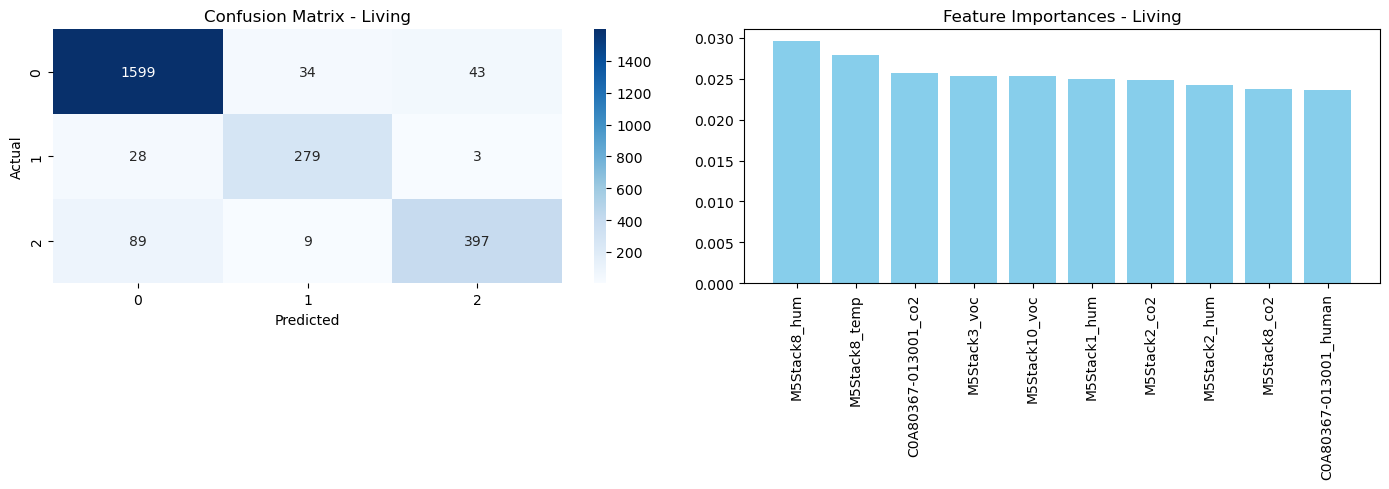


★ Japanese (Washitu) の人数推定を開始します (Target: Label_Japanese_Count)
[Japanese (Washitu)] データ拡張を実行中...
[Japanese (Washitu)] 学習データ数: 5789 => 40523 (約7.0倍)
[Japanese (Washitu)] モデル学習中...

★ Japanese (Washitu) 正解率 (Accuracy): 0.9597
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2000
           1       0.90      0.97      0.94       186
           2       0.90      0.82      0.86       295

    accuracy                           0.96      2481
   macro avg       0.92      0.92      0.92      2481
weighted avg       0.96      0.96      0.96      2481



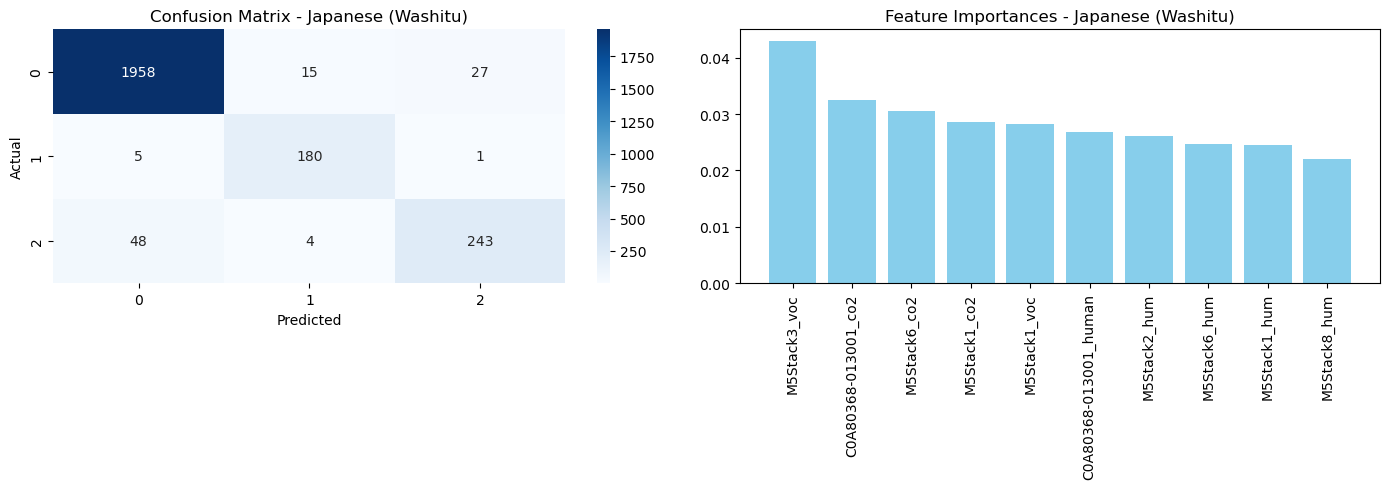


全ての処理が完了しました。


In [12]:
# ==============================================================================
# ライブラリのインポート
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 日本語フォント設定（Mac用: AppleGothic, Windows用: Meiryoなど適宜変更）
# plt.rcParams['font.family'] = 'AppleGothic'

# ==============================================================================
# 1. データの読み込み
# ==============================================================================
# ★ここに読み込みたいファイル名をリストで記述してください
file_names = ["smart_home_0101.csv", "smart_home_1229-1.csv", "smart_home_1231.csv"]
data_list = []

print("データを読み込んでいます...")
for file in file_names:
    try:
        df = pd.read_csv(file)
        data_list.append(df)
        print(f" - {file}: 読み込み完了 ({len(df)} 行)")
    except FileNotFoundError:
        print(f" - {file}: ファイルが見つかりません。")

if not data_list:
    raise ValueError("読み込めるデータがありませんでした。")

full_data = pd.concat(data_list, ignore_index=True)

# タイムスタンプがあればソート（時系列順に整列）
if "timestamp" in full_data.columns:
    full_data["timestamp"] = pd.to_datetime(full_data["timestamp"])
    full_data = full_data.sort_values("timestamp").reset_index(drop=True)

# ==============================================================================
# 2. 前処理 (共通)
# ==============================================================================
# 欠損値補完（新しい書き方）
full_data = full_data.bfill().ffill().fillna(0)

# 特徴量の自動選択 (全センサーを使用)
# "_co2", "_temp" などが含まれる列と "PIR" が含まれる列を抽出
sensor_cols = [
    c
    for c in full_data.columns
    if any(x in c for x in ["_co2", "_temp", "_hum", "_voc", "_pm2_5"])
]
pir_cols = [c for c in full_data.columns if "PIR" in c]

# ここで数値データ以外（文字列など）が混ざらないようにフィルタリング
numeric_cols_only = full_data.select_dtypes(include=["number", "bool"]).columns
features = [c for c in (sensor_cols + pir_cols) if c in numeric_cols_only]

print(f"使用する特徴量の数: {len(features)}")
# print(features) # 特徴量の中身を見たい場合はコメントアウトを外す


# ==============================================================================
# 3. 強化版データオーグメンテーション関数
# ==============================================================================
def augment_data_enhanced(
    X, y, noise_level=0.05, shift_steps=[-2, -1, 1, 2], scaling_range=(0.95, 1.05)
):
    """
    データ拡張を行う関数（強化版）
    1. ノイズ付加: センサーの微細な揺らぎを再現
    2. タイムシフト: 応答遅れや早まりを再現（範囲拡大）
    3. スケーリング: センサー感度の個体差や環境差を再現
    """
    X_aug_list = [X]
    y_aug_list = [y]

    # 数値カラムのみ抽出（計算エラー防止）
    numeric_cols = X.select_dtypes(include=[np.number]).columns

    # --- 1. ノイズ付加 (Gaussian Noise) ---
    noise = np.random.normal(0, noise_level, X[numeric_cols].shape)
    X_noise = X.copy()
    X_noise[numeric_cols] = X_noise[numeric_cols] + noise
    X_aug_list.append(X_noise)
    y_aug_list.append(y)

    # --- 2. タイムシフト (Time Shift) ---
    for step in shift_steps:
        X_shifted = X.shift(step).bfill().ffill()
        X_aug_list.append(X_shifted)
        y_aug_list.append(y)

    # --- 3. スケーリング (Scaling) ---
    # 値全体をランダムに 0.95倍 ~ 1.05倍 する
    factor = np.random.uniform(scaling_range[0], scaling_range[1])
    X_scaled = X.copy()
    X_scaled[numeric_cols] = X_scaled[numeric_cols] * factor
    X_aug_list.append(X_scaled)
    y_aug_list.append(y)

    return pd.concat(X_aug_list, ignore_index=True), pd.concat(
        y_aug_list, ignore_index=True
    )


# ==============================================================================
# 4. 学習と評価のループ (リビング・和室 それぞれ実行)
# ==============================================================================
target_rooms = {
    "Living": "Label_Living_Count",  # リビングの正解ラベル
    "Japanese (Washitu)": "Label_Japanese_Count",  # 和室の正解ラベル
}

for room_name, target_col in target_rooms.items():
    print(f"\n" + "=" * 60)
    print(f"★ {room_name} の人数推定を開始します (Target: {target_col})")
    print("=" * 60)

    # ターゲットがない場合はスキップ
    if target_col not in full_data.columns:
        print(f"[Skip] {target_col} がデータに含まれていません。")
        continue

    # モデル用データの作成
    df_model = full_data[features + [target_col]].copy()
    df_model.dropna(subset=[target_col], inplace=True)

    X = df_model[features].copy()
    y = df_model[target_col].copy()

    # Boolean -> Int 変換
    for col in X.select_dtypes(include=["bool"]).columns:
        X[col] = X[col].astype(int)

    # データの分割 (Shuffle=True で多様なパターンを学習)
    # ※時系列を厳密に見るなら shuffle=False にしてください
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, shuffle=True
    )

    # データ拡張の実行
    print(f"[{room_name}] データ拡張を実行中...")
    original_size = len(X_train)

    # 強化版関数を使用
    X_train_aug, y_train_aug = augment_data_enhanced(
        X_train,
        y_train,
        noise_level=0.05,
        shift_steps=[-2, -1, 1, 2],
        scaling_range=(0.95, 1.05),
    )

    print(
        f"[{room_name}] 学習データ数: {original_size} => {len(X_train_aug)} (約{len(X_train_aug)/original_size:.1f}倍)"
    )

    # 学習
    print(f"[{room_name}] モデル学習中...")
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",  # 少数派クラス（2人など）を重視
        random_state=42,
        n_jobs=-1,
    )
    model.fit(X_train_aug, y_train_aug)

    # 評価
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n★ {room_name} 正解率 (Accuracy): {acc:.4f}")

    # warningが出ないように zero_division=0 を設定
    print(classification_report(y_test, y_pred, zero_division=0))

    # --- 可視化 ---
    plt.figure(figsize=(14, 5))

    # 1. 混同行列 (Confusion Matrix)
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {room_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # 2. 特徴量重要度 (Top 10)
    plt.subplot(1, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]  # Top 10

    plt.title(f"Feature Importances - {room_name}")
    plt.bar(range(10), importances[indices], align="center", color="skyblue")
    plt.xticks(range(10), [features[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

print("\n全ての処理が完了しました。")